# Feature Extraction with Pre-trained Models

In the earlier notebooks, we demonstrated how to build **autoencoder** as a feature extraction tool. The results of convolutional AE seemed promising for its reconstructions preserve most visible features. However, training a new model for 

Another way to do feature extraction is to leverage **pre-trained models** with **fine-tuning**. The [tensorflow model hub](https://tfhub.dev/) hosts many pre-trained models. For example, the [Feature vectors of ResNet-50 model pre-trained on BigEarthNet remote sensing dataset](https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1) is a popular model for remote-sensing datasets.

In this notebook, we are going to illustrate this process.


## Extra Data Preprocessing: Resize

The data pre-processing functions developed earlier yields a (858,858) image. Here we add a *resize* step to change the resolutions for further processing. ([`opencv.resize`](https://pythonexamples.org/python-opencv-cv2-resize-image/) is used.)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os, argparse, logging
import cv2

# Utility functions
def list_noaagridsatb1_files(dir, suffix='.v02r01.nc', to_remove=['GRIDSAT-B1.','.v02r01.nc']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_noaagridsatb1(furi, var='irwin_cdr', scale=0.01, offset=200, remove_na=True, crop_east_asia=True, rescale=512):
    ''' The method reads in a NOAA-GridSta-B1 image in netCDF4 format (.nc file). 
        The brightness temperature data was stored in int16 as 'irwin_cdr', with 
        a scal factor of 0.01 and offset of 200. The missing values is flagged as -31999.
        More details of the data is described in https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_GRIDSAT-B1_V2.
        Since our analysis focuss on East Asia (0-60'N, 100-160'E), we used an 
        option to crop the data to this region (index: lat:1000~1858, lon:4000~4858).
        The output is a 2-d numpy array of float32 with shape (858, 858).
    '''
    import numpy as np
    import netCDF4 as nc
    import cv2
    # Read in data
    data = nc.Dataset(furi)
    cdr = np.array(data.variables['irwin_cdr'])*scale+offset
    # Remove missing value
    if remove_na:
        cdr[cdr<0] = offset
    # Crop domain to East-Asia (0-60'N, 100-160'E)
    if crop_east_asia:
        tmp = cdr[0, 1000:1858, 4000:4858]
        #output = cv2.resize(tmp, (rescale,rescale), interpolation=cv2.INTER_CUBIC)
        return(tmp)
    else:
        return(cdr[0,:,:])

def read_multiple_noaagridsatb1(flist):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = read_noaagridsatb1(f)
        #ny, nx = tmp.shape
        if tmp is not None:
            #tmp = tmp.reshape((ny, nx, 1))
            data.append(tmp)
    return(np.array(data, dtype=np.float32))

def data_generator_ae(flist, batch_size, add_dim=False):
    ''' Data generator for batched processing. '''
    nSample = len(flist)
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = read_multiple_noaagridsatb1(flist[batch_start:limit])
            if add_dim:
                X = np.expand_dims(X, axis=3)
            #print(X.shape)
            yield (X,X) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
    # End of generator

       timestamp                                               xuri
0  2015.06.01.00  D:/worksapce/2020Q3_representation_learning/da...
1  2015.06.01.03  D:/worksapce/2020Q3_representation_learning/da...
2  2015.06.01.06  D:/worksapce/2020Q3_representation_learning/da...
3  2015.06.01.09  D:/worksapce/2020Q3_representation_learning/da...
4  2015.06.01.12  D:/worksapce/2020Q3_representation_learning/da...
(858, 858)


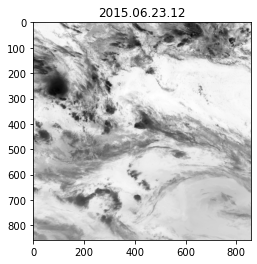

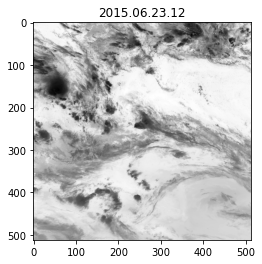

In [11]:
# Test
# Define parameters
datadir = 'D:/worksapce/2020Q3_representation_learning/data/noaa'
finfo = list_noaagridsatb1_files(datadir)
print(finfo.head())
# Load data
data = read_noaagridsatb1(finfo['xuri'].iloc[180])
print(data.shape)
data2 = cv2.resize(data, (512,512), interpolation=cv2.INTER_CUBIC)

# Visualize the process
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(data)
plt.title(finfo['timestamp'].iloc[180])
plt.gray()
plt.show()


plt.imshow(data2)
plt.title(finfo['timestamp'].iloc[180])
plt.gray()
plt.show()

In [12]:
module = hub.Module("https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1")
module.summary()

NameError: name 'hub' is not defined

In [ ]:
images = [data2] # A batch of images with shape [batch_size, height, width, 3].
features = module(images)  # Features with shape [batch_size, num_features].